# CELLxGENE Discover Census scvi-tools initial autotune report

Author: Martin Kim (martinkim@berkeley.edu)

Date: 2023-09-28

## 1. Introduction

To prepare for training an scVI model on the CELLxGENE Discover single-cell RNA-seq corpus and making cell embeddings queryable in the Census, we performed hyperparameter validation. This notebook presents data from human and mouse autotune runs, summarizes key findings, and outlines future research directions. The goal is that, with the conclusions drawn in this notebook, we can confidently deliver a beta release of model embeddings through the Census and then iterate further from there.

Running this notebooks requires `matplotlib`, `pandas`, and `seaborn`.

In [1]:
import os

from utils import (
    get_trial_dirs, 
    get_trial_ids, 
    get_trial_info, 
    get_trial_params, 
    get_trial_progress, 
    plot_trials,
)

## 2. Methods

### 2.1 Glossary

We start by presenting an overview of the model and training parameters referenced throughout this notebook, including their descriptions and current default values in `scvi-tools`:

- `n_hidden`: Number of nodes per hidden layer in the encoder and decoder (default is `128`)
- `n_layers`: Number of hidden layers in the encoder and decoder (default is `1`)
- `n_latent`: Dimensionality of the model's latent space (default is `10`)
- `lr`: Fixed learning rate of the optimizer (default is `1e-3`)
- `batch_size`: Size of the mini-batches seen during each training iteration (default is `128`)
- `var_activation`: Non-negative activation function over the posterior variance in the encoder (default is the exponential)

### 2.2 Search spaces

The search space specifies the model and training parameters we want to examine in order to understand their impact on model performance, specifically the validation loss. The following outlines the search spaces for tunable parameters, as well as any fixed hyperparameters that deviate from their default settings in `scvi-tools`:

```{python}
v1_search_space = {
    "n_hidden": [128, 256, 512]
    "n_layers": [1, 10, 25],
    "n_latent": [10, 50, 100],
    "lr": [1e-2, 1e-3, 1e-4],
    "batch_size": [512, 1024, 2048],
}
v1_non_default_model_parameters = {
    "var_activation": "softplus"
}
```
The search space above was tuned over a random subset (1/10) of the human data (~3,000,000 cells), the full human data (~30,000,000 cells), and the full mouse data (~3,000,000 cells). The goal of this first search space was to generally explore how the model size (`n_hidden`, `n_layers`, `n_latent`) should scale with the size of the data as well as the role that the learning rate and batch size play in the stability of model training.

After the results of the first search space were analyzed, the behavior of `n_layers` and `n_latent` was inconclusive, thus the second search space included additional values for these along with fixed non-default values for all other parameters.

```{python}
v2 = {
    "n_layers": [1, 2, 5],
    "n_latent": [50, 100, 200],
}
v2_non_default_model_parameters = {
    "n_hidden": 512,
    "var_activation": "softplus",
}
v2_non_default_train_parameters = {
    "lr": 1e-4,
    "batch_size": 1024,
}
```

Note that both search spaces set the variance activation to the softplus instead of the default exponential. This is because, prior to the autotune runs, it was observed that the exponential led to frequent NaN values during model training. The softplus has anecdotally led to more stable training.

### 2.3 Autotune algorithms

Two key components in an autotune run are the scheduler and search algorithms. The former slates which trials (*i.e.* models with a set of hyperparameters sampled from the search space) are to run concurrently and for how many training epochs, and the latter determines how new sets of hyperparameters are sampled from the search space. In `scvi.autotune`, we rely on [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for both of these components. The following were used for all autotune runs:

- [Asynchronous HyperBand scheduler](https://openreview.net/forum?id=S1Y7OOlRZ): Adaptively assigns more computational resources (training epochs) to more promising candidates (trials with lower validation losses that decrease quickly) and prunes less promising ones early. It does so in an asynchronous manner such that trials don't need to wait for one another to complete.
- [Tree-structured Parzen Estimators](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf): Estimates the objective function (validation loss) as two distributions, one for "good" hyperparameters and another for "bad" ones. Using information from trials that have completed, it updates its approximation to sample new hyperparameters based on the greatest Expected Improvement.

The combination of these two algorithms ensures that underperforming trials are stopped early and that new trials are sampled in a more sophisticated manner compared to random sampling. This ensures that computing resources (GPU time) are utilized more efficiently.

A large downside of using these types of algorithms is that we might end up terminating potentially performant models (*e.g.* models that initially perform poorly but end up outperforming other models) due to the scheduler pruning trials too early or the search algorithm incorrectly focusing on unpromising areas of the search space.

## 3. Results

We start by reading in the log files for each autotune experiment, and then we will inspect the training curves generated by the experiments with respect to each hyperparameter.

In [2]:
EXPERIMENT_IDS = [
    "2023_08_22_human_full", # v1
    "2023_08_22_human_tenth", # v1
    "2023_09_06_mouse_full", # v1
    "2023_09_12_human_full", # v2
    "2023_09_12_mouse_full", # v2
]
v1_search_params = [
    "n_hidden",
    "n_layers",
    "n_latent",
    "lr",
    "batch_size",
]
v2_search_params = [
    "n_layers",
    "n_latent",
]
ROOT_DIR = "../logs"
V1_DATES = ("2023_08_22", "2023_09_06")
V2_DATES = ("2023_09_12")
TRIAL_IDS_KEY = "trial_ids"
TRIAL_PARAMS_KEY = "trial_params"
TRIAL_PROGRESS_KEY = "trial_progress"
TRIAL_INFO_KEY = "trial_info"

In [3]:
experiments = {}

for experiment_id in EXPERIMENT_IDS:
    if experiment_id.startswith(V1_DATES):
        search_params = v1_search_params
    elif experiment_id.startswith(V2_DATES):
        search_params = v2_search_params

    experiment_dir = os.path.join(ROOT_DIR, experiment_id)
    trial_dirs = get_trial_dirs(
        experiment_dir, 
        filter_incomplete=True, 
        filter_lightning=True
    )
    trial_ids = get_trial_ids(trial_dirs)

    trial_params = {
        trial_id: get_trial_params(
            experiment_dir, 
            trial_dir, 
            search_params
        ) for trial_id, trial_dir in zip(trial_ids, trial_dirs)
    }
    trial_progress = {
        trial_id: get_trial_progress(
            experiment_dir, 
            trial_dir
        ) for trial_id, trial_dir in zip(trial_ids, trial_dirs)
    }
    trial_info = get_trial_info(trial_params, trial_progress)

    experiments[experiment_id] = {
        TRIAL_IDS_KEY: trial_ids,
        TRIAL_PARAMS_KEY: trial_params,
        TRIAL_PROGRESS_KEY: trial_progress,
        TRIAL_INFO_KEY: trial_info,
    }

Missing progress.csv for _trainable_b6d775cc_1_batch_size=2048,lr=0.0100,n_hidden=256,n_latent=10,n_layers=10,var_activation=ref_ph_ecd03db6_2023-08-17_16-39-25
Missing progress.csv for _trainable_f8003819_45_batch_size=2048,lr=0.0100,n_hidden=256,n_latent=50,n_layers=1,var_activation=ref_ph_ecd03db6_2023-08-21_14-51-17
Missing progress.csv for _trainable_2d9a9cf5_141_batch_size=2048,lr=0.0100,n_hidden=128,n_latent=100,n_layers=25,var_activation=ref_ph_ecd03db6_2023-08-17_16-31-33
Missing progress.csv for _trainable_57c97f03_41_batch_size=512,lr=0.0001,n_hidden=512,n_latent=100,n_layers=25,var_activation=ref_ph_ecd03db6_2023-08-19_07-56-10
Missing progress.csv for _trainable_c000f380_147_batch_size=512,lr=0.0100,n_hidden=128,n_latent=100,n_layers=1,var_activation=ref_ph_ecd03db6_2023-08-17_16-31-43


Before diving into the results, we note the following caveats about hyperparameter optimization results in general:

- In deep learning models, variability between trials can arise from factors like random train-validation splits, mini-batch sampling during training, or non-deterministic CUDA operations. To mitigate this, we use a consistent random seed for all trials, although a degree of skepticism should still be applied to the results.
- As mentioned before, the selection of schedulers and search algorithms can significantly impact the trials conducted. While advanced algorithms offer advantages over random sampling and FIFO scheduling, they are not perfect and may give misleading results.
- In our autotune experiments, the validation loss was used as the objective function, which is calculated using a random 10% split of the original data. Although this metric is useful for assessing overfitting, generalization, and convergence, it may not fully capture other model aspects we're interested in such as biological conservation in the latent space or integration with respect to technical covariates.

With that in mind, this section will be analyzing the following aspects of each trial:

- Overfit: Occurs when the model fits the training data too well such that it does not generalize to the validation set. This can be assessed by comparing the relative difference between the training and validation losses, and also observing whether the validation decreases in the beginning and then goes back up again.
- Underfit: Occurs when the model is unable to fit the training or validation data performantly. This can be observed when neither the training or validation losses decrease quickly.
- Convergence: Occurs when the model reaches a point during training where the validation loss does not significantly increase or decrease with further iterations. 
- Stability: Measured by the consistency in training and validation losses, observing any spikes or monotonic trends.

### 3.1 `n_hidden`

We now present a plot of validation losses from 403 trials in the v1 full human data experiment. Each line represents a single trial, color-coded by `n_hidden`. Notice that the number of training epochs differs between trials due to the scheduler's pruning behavior. The y-axis is truncated for clarity.

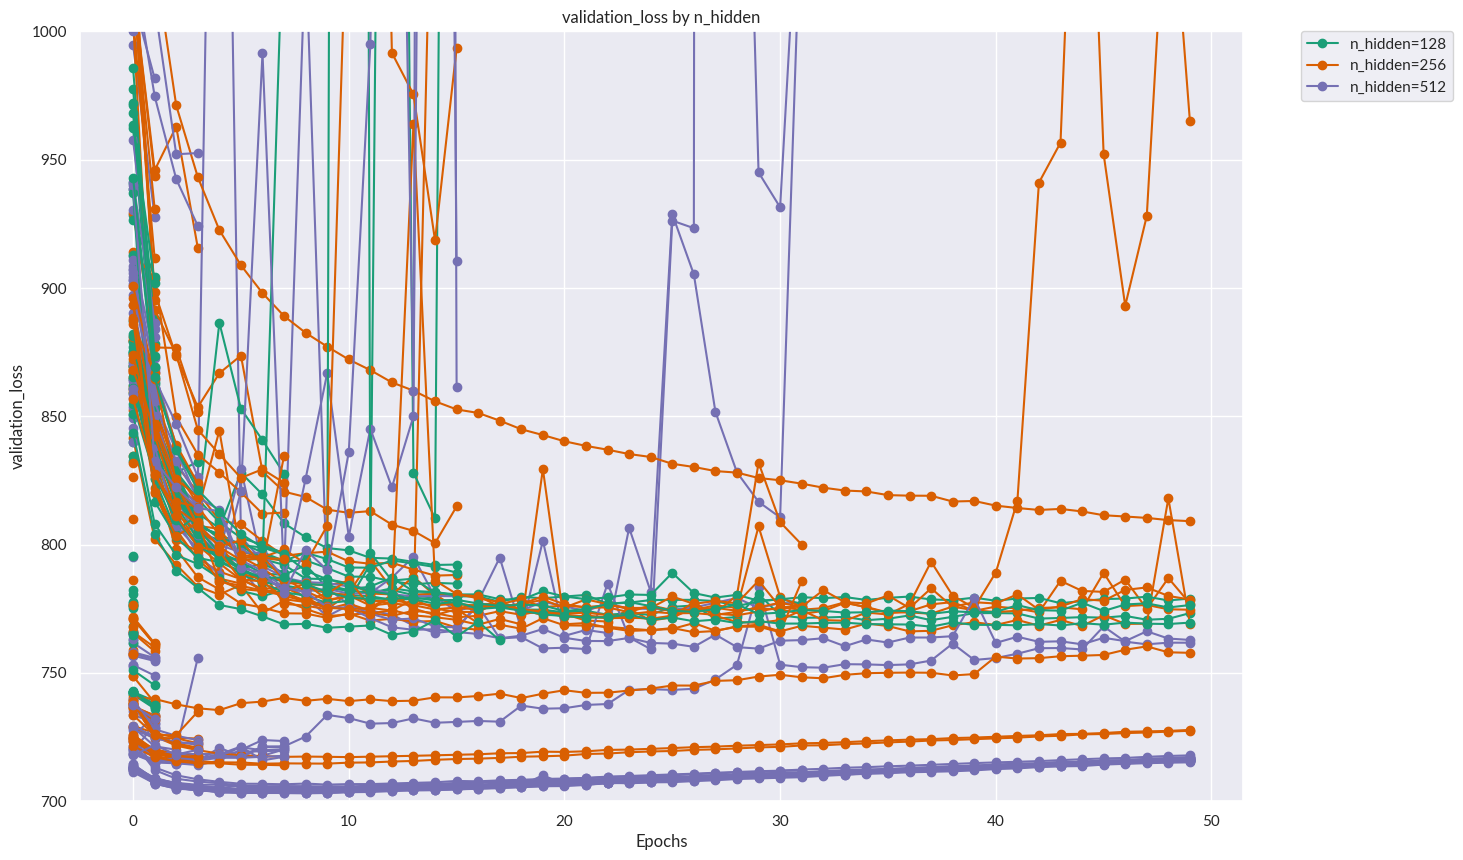

In [4]:
experiment_id = "2023_08_22_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_hidden",
    figsize=(15, 10),
    ylim=(700, 1000),
)

We observe the following:

- Stability varies between trials - some exhibit many spikes and non-monotonic loss reduction. Initial instability often persistens throughout training.
- Trials with larger `n_hidden` values (`256` and `512`) generally achieve lower validation losses and converge around epoch 10.
- Top-performing trials show strong performance from the first epoch.

We now show the same plot but for the v1 full mouse data experiment (50 trials).

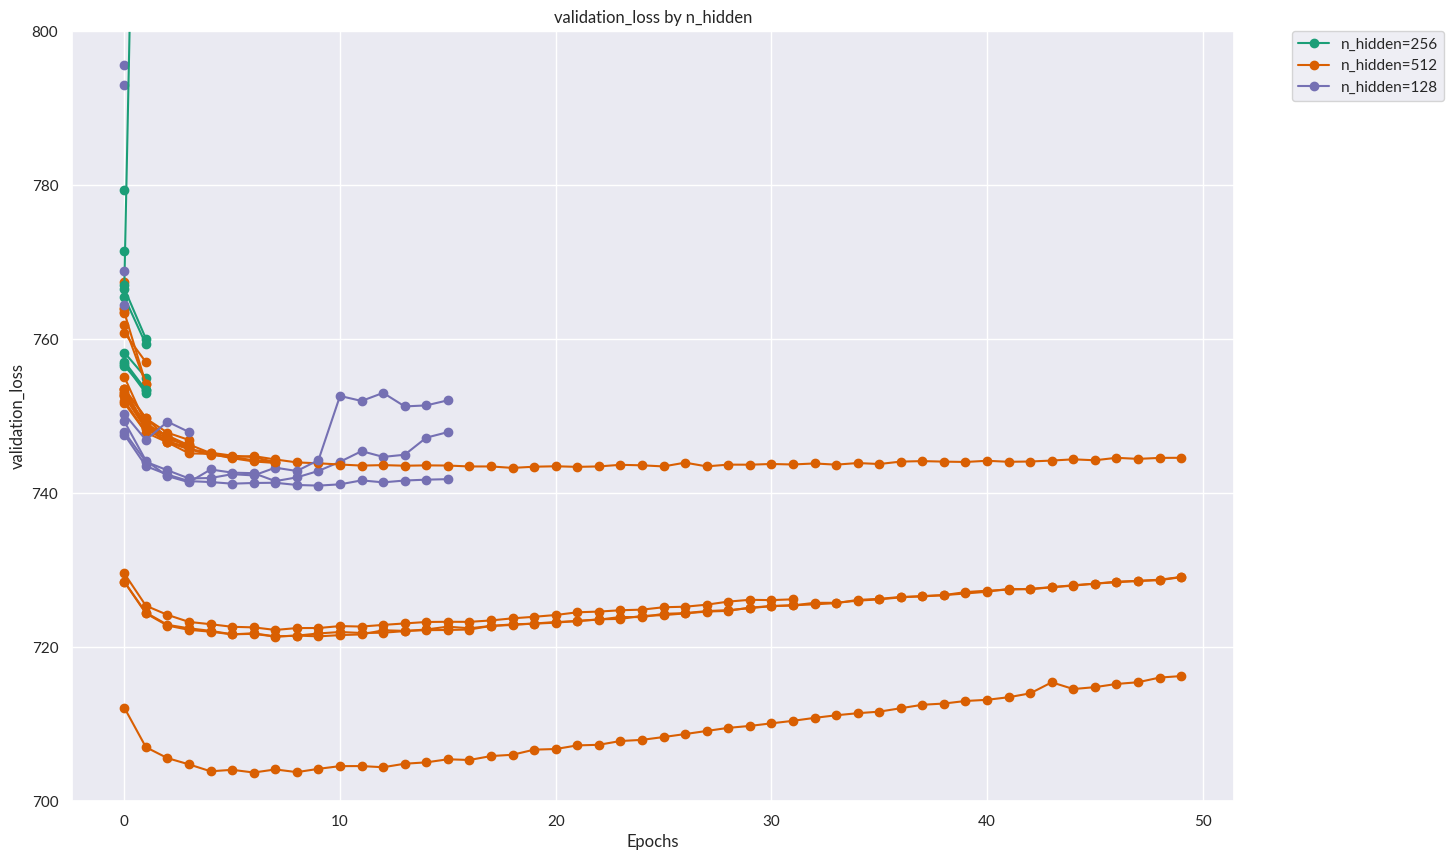

In [5]:
experiment_id = "2023_09_06_mouse_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_hidden",
    figsize=(15, 10),
    ylim=(700, 800),
)

We observe the following:

- Similar to before, we see `n_hidden=512` for top-performing trials, albeit with a smaller sample size.
- In this case too, trials seem to converge at around 10 epochs or less, showing minimal overfitting thereafter.



### 3.2 `n_layers`

We now plot the validation losses for 50 trials in the v1 human tenth experiment, color coded by `n_layers`.

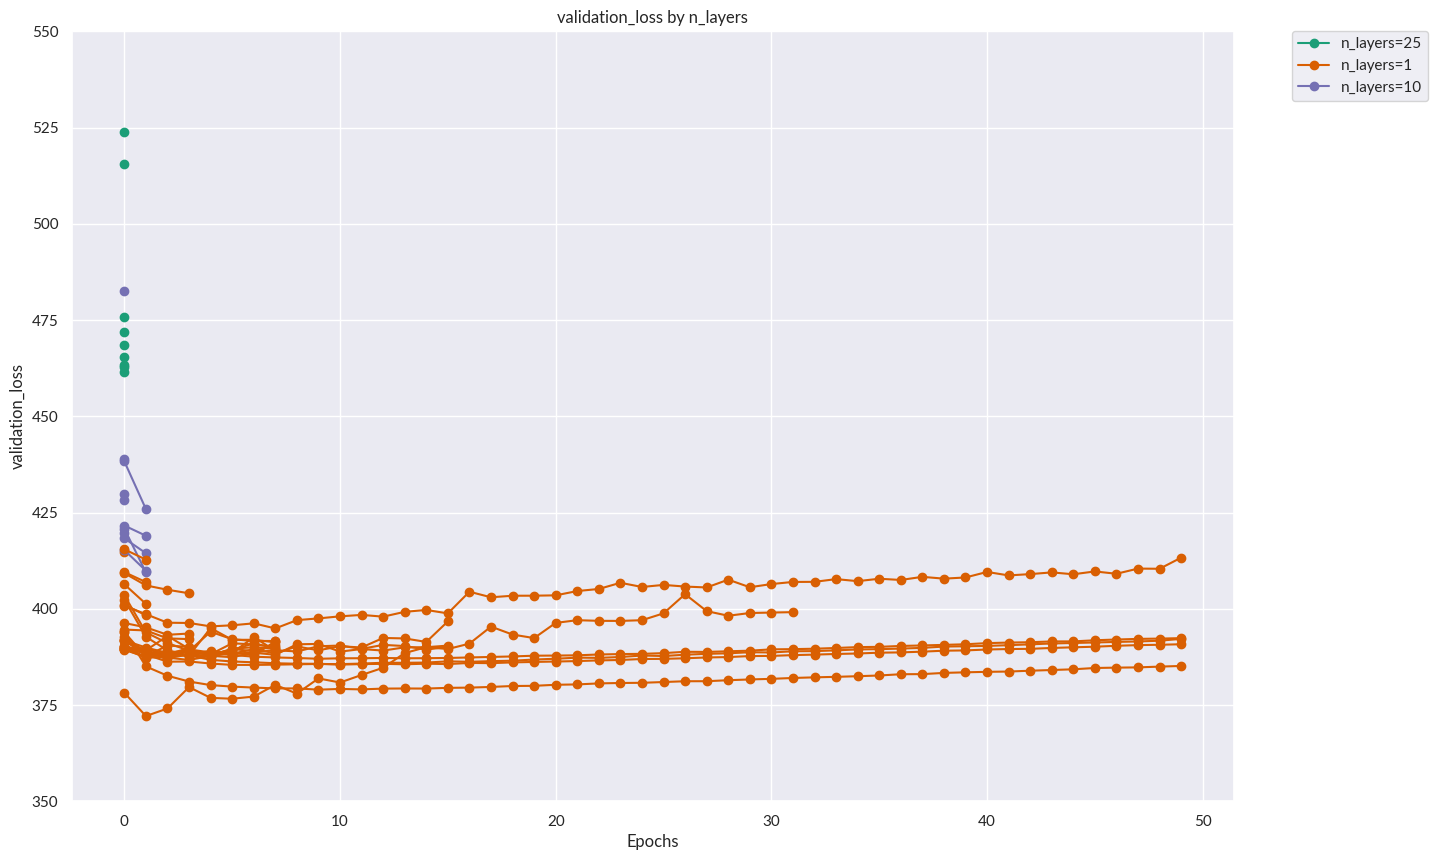

In [27]:
experiment_id = "2023_08_22_human_tenth"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_layers",
    figsize=(15, 10),
    ylim=(350, 550),
)

We observe the following:

- Most samples feature `n_layers=1`, and the scheduler predominantly extends training duration for trials with this value.
- Any value larger than `n_layers=1` generally starts off with higher validation losses.
- Tentatively, model performance decreases monotonically when increasing `n_layers`.
  
We can compare this plot to the v1 full human data experiment:

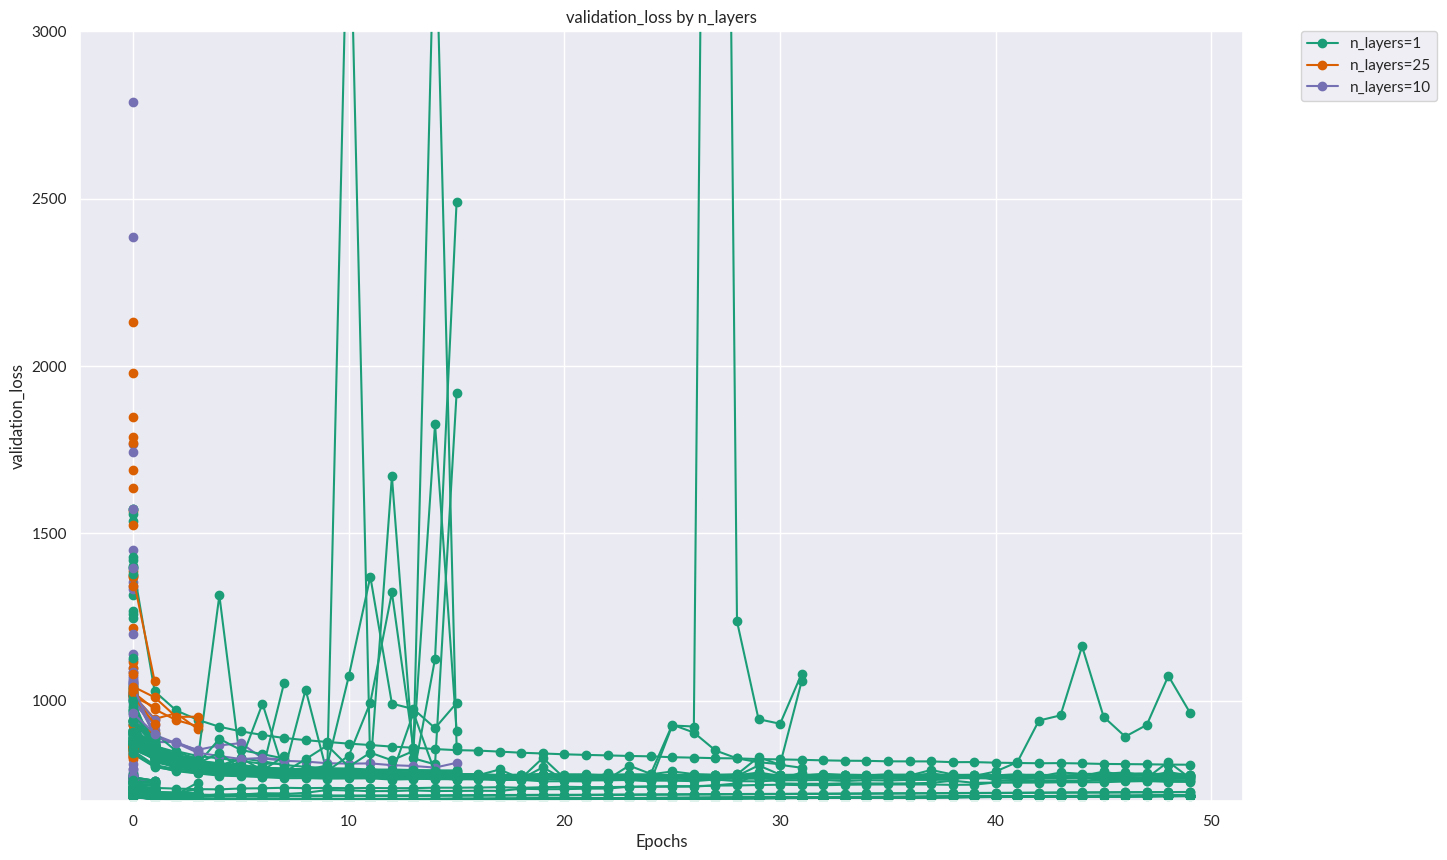

In [34]:
experiment_id = "2023_08_22_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_layers",
    figsize=(15, 10),
    ylim=(700, 3000),
)

We observe the following:

- Similar to the previous plot, the top-performing trials have `n_layers=1`.
- Trials with `n_layers=1` vary widely in terms of stability and overfitting, so this is probably dependent on some other parameter.

Finally, we present the plot for the v1 full mouse experiment, which shows similar patterns to the previous two.

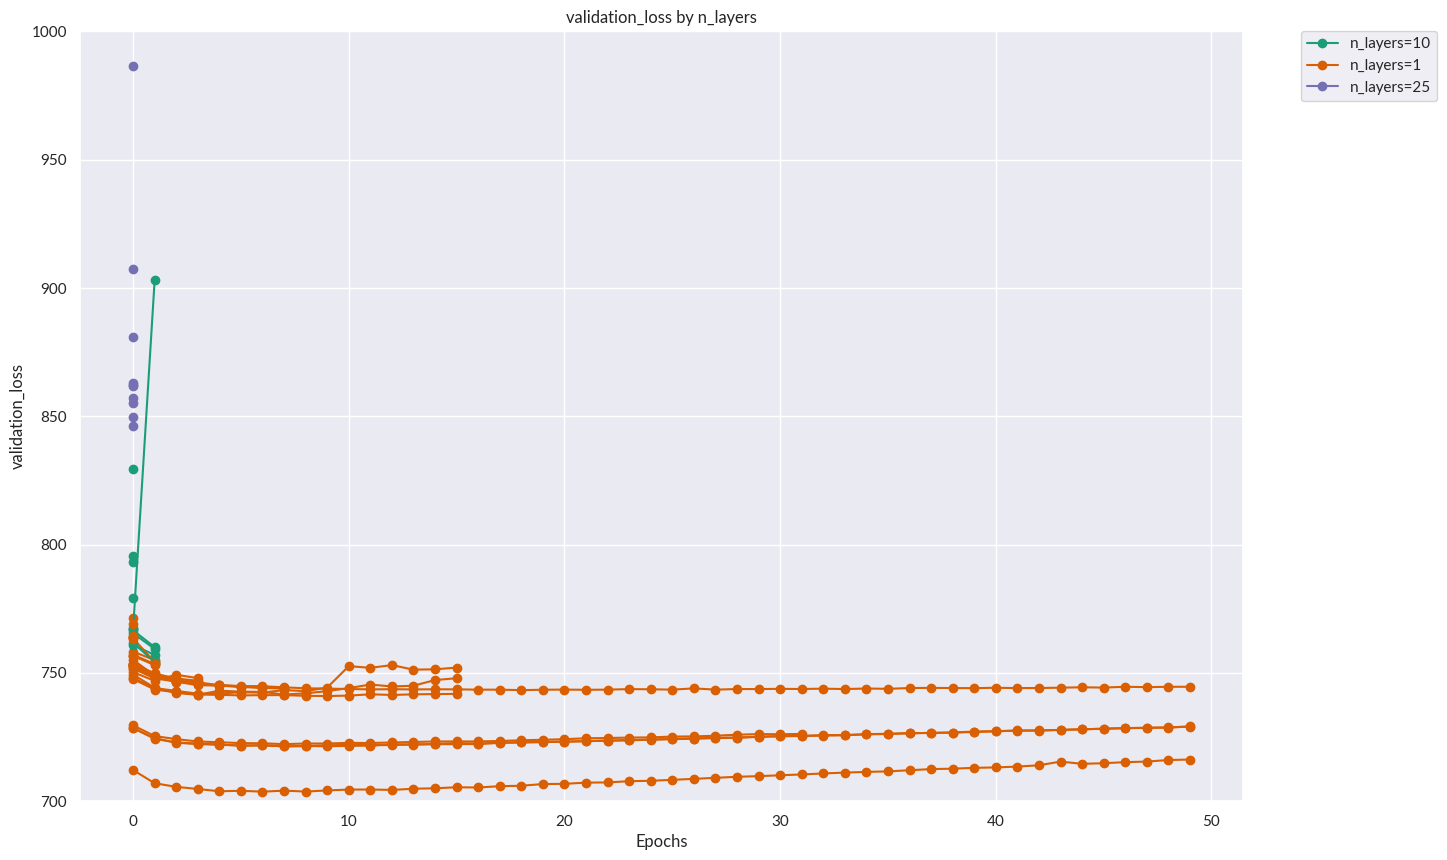

In [25]:
experiment_id = "2023_09_06_mouse_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_layers",
    figsize=(15, 10),
    ylim=(700, 1000),
)

After these initial results, the main question was whether the search space was too wide for this parameter. In the next two experiments, we narrowed the choices for `n_layers` to assess whether larger values consistently lead to decreased performance.

The next two plots present data from v2 experiments on the full human and full mouse data, respectively.

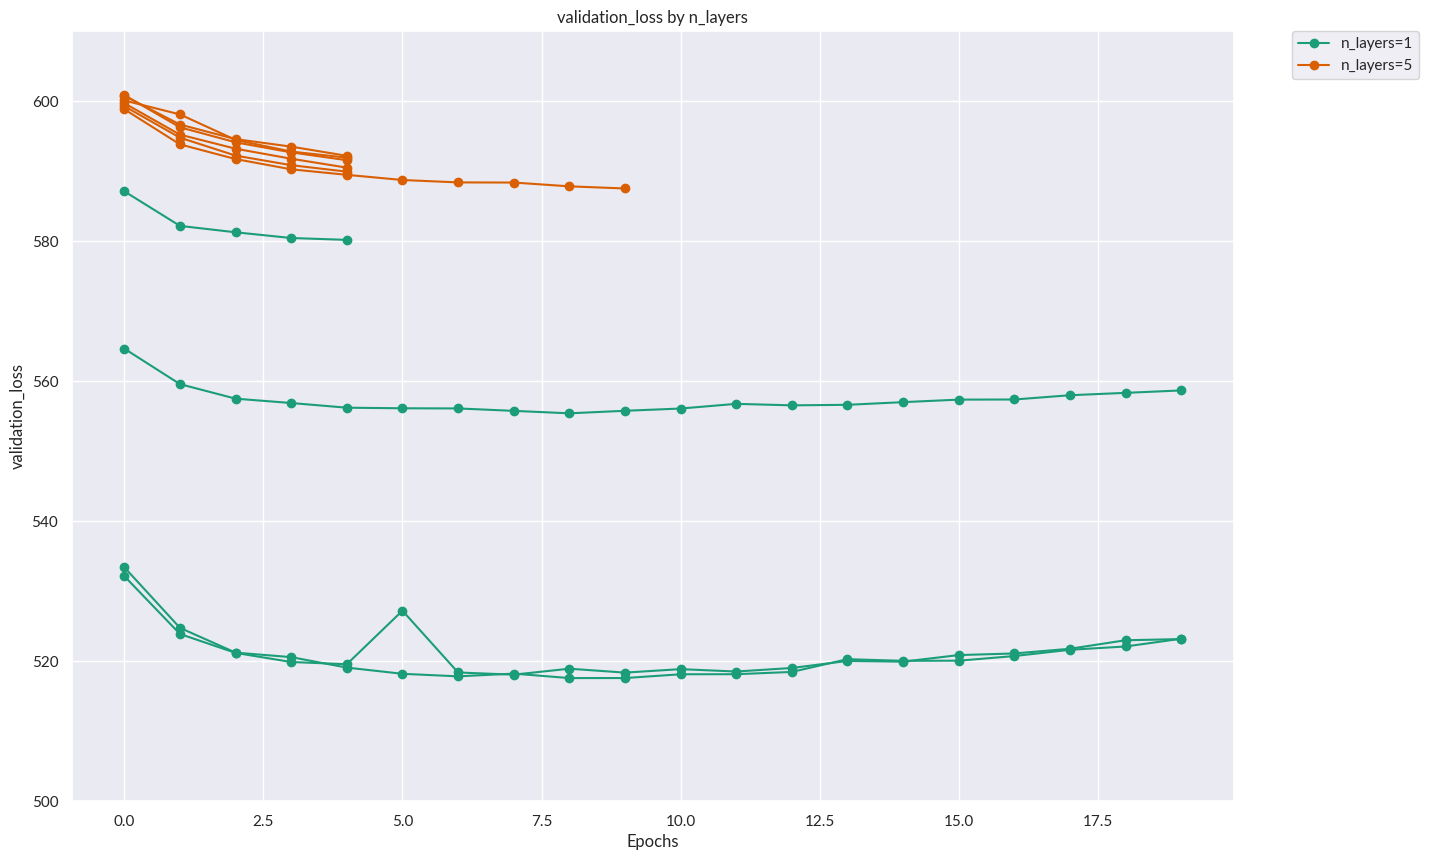

In [36]:
experiment_id = "2023_09_12_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_layers",
    figsize=(15, 10),
    ylim=(500, 610),
)

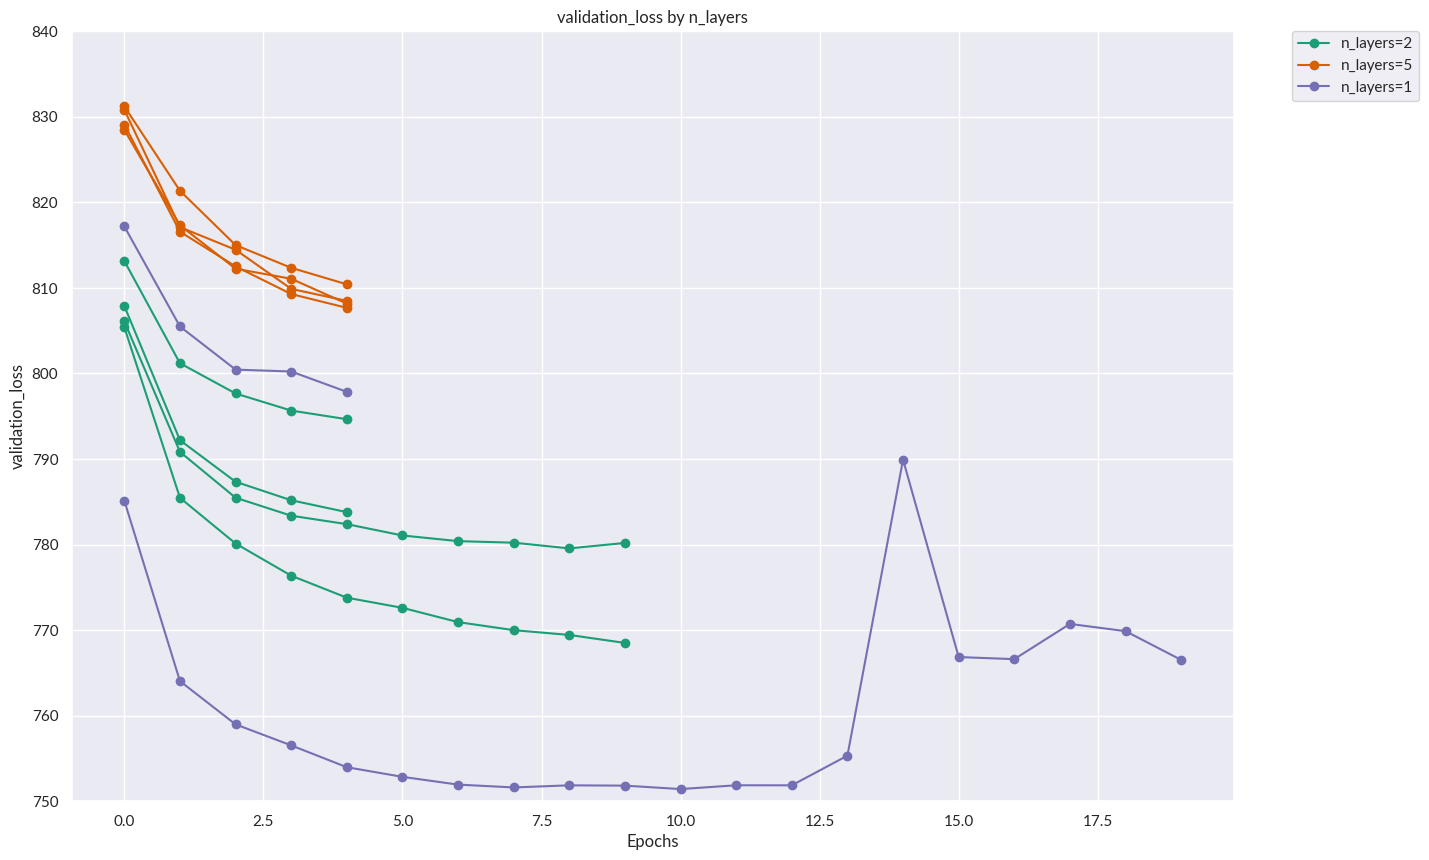

In [10]:
experiment_id = "2023_09_12_mouse_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_layers",
    figsize=(15, 10),
    ylim=(750, 840),
)

Although a smaller sample size, we see the same relationship here between `n_layers` and `validation_loss`, where larger values are not as performant. 

### 3.3 `n_latent`

Prior to the experiments, `n_latent` was hypothesized to be one of the most important parameters affecting model performance as it determines the size of the model's bottleneck, thus limiting or expanding how much information can be encoded through the latent space.

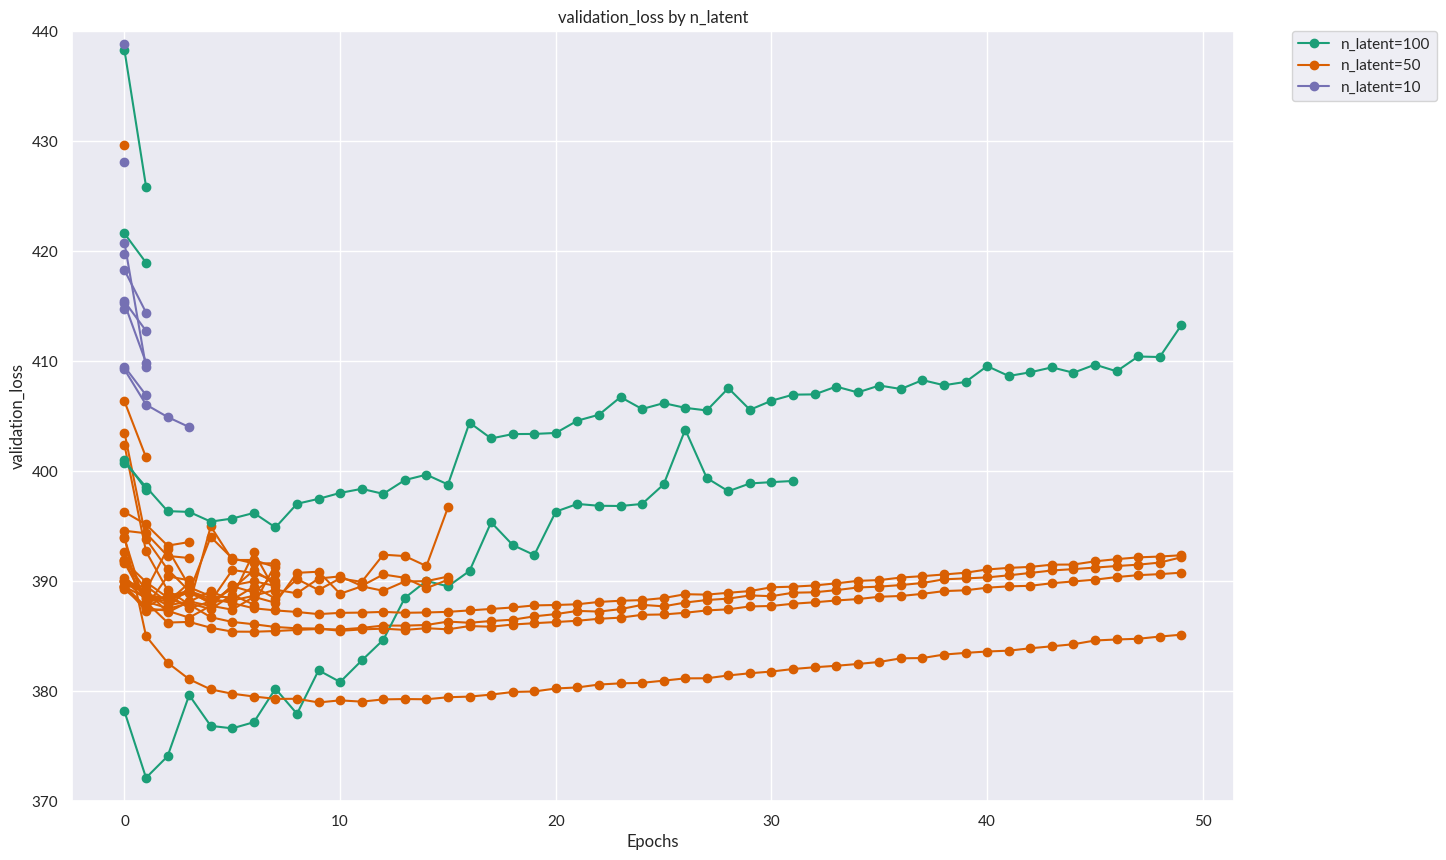

In [38]:
experiment_id = "2023_08_22_human_tenth"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_latent",
    figsize=(15, 10),
    ylim=(370, 440),
)

For the v1 human tenth experiment, it is clear that the sweet spot is an intermediate value (`n_latent=50`), where a smaller value (`n_latent=10`) does not lead to a good model fit, while a larger value (`n_latent=100`) leads to overfitting and instability. This, however, is not the case for the full human dataset below. In this second plot, we see that `n_latent=100` leads to more performant models. An interpretation of this is that a larger latent space is required for increasing complexity in the data - the model needs a larger bottleneck in order to effectively encode more data.

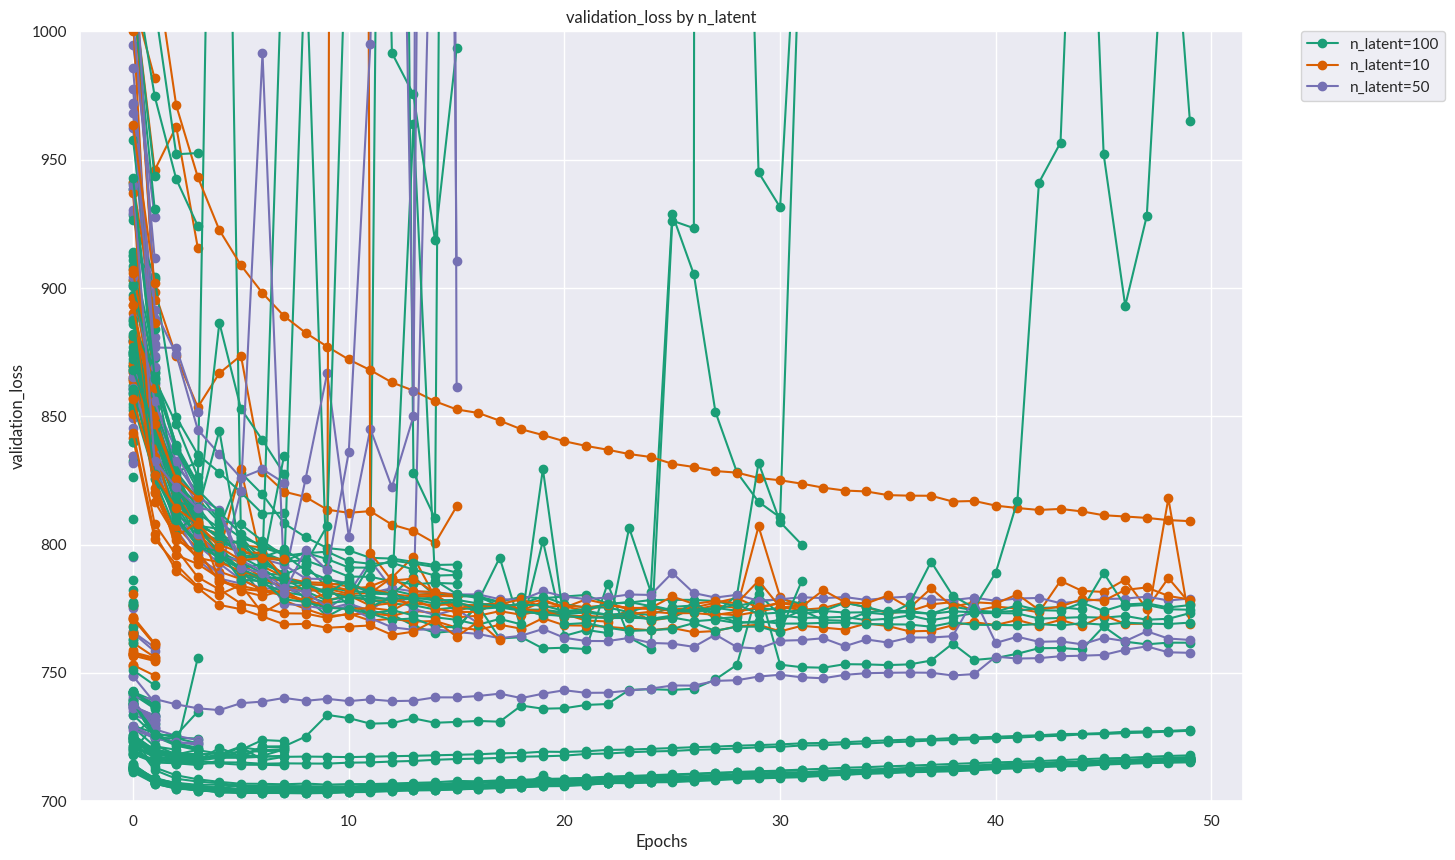

In [12]:
experiment_id = "2023_08_22_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_latent",
    figsize=(15, 10),
    ylim=(700, 1000),
)

Based off of these initial results, we were interested in whether `n_latent` could be scaled up further without hurting model generalization. For the v2 search space, we increased the maximum value of `n_latent` to `200` and found it to perform even better.  

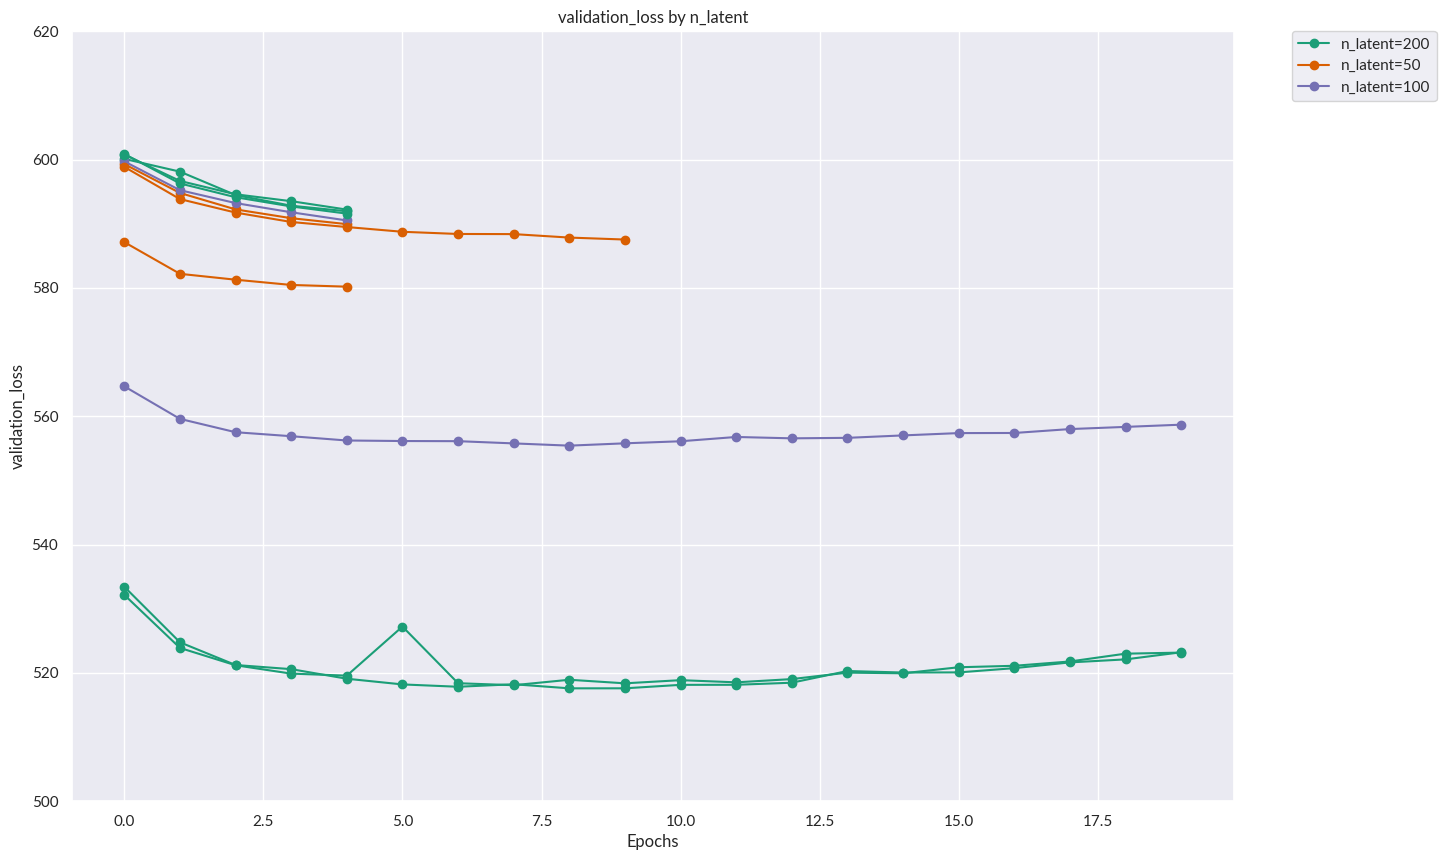

In [14]:
experiment_id = "2023_09_12_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "n_latent",
    figsize=(15, 10),
    ylim=(500, 620),
)

### 3.4 `lr`

The optimizer's learning rate controls how quickly or slowly the model parameters are updated in each training iteration, and thus a well-tuned learning rate can significantly improve model performance. A large learning rate can be favorable when it leads to faster convergence due to larger model updates, but if it is too large, it can lead to instability as the parameters are unable to settle on the optimum. A smaller learning rate can lead to more stable training at the cost of slower convergence.

In the three plots below (human tenth, human full, mouse full), we observe the following:

- Smaller learning rates (`1e-3` and `1e-4`) are preferred across all datasets, with `lr=1e-4` outperforming on the human tenth, `lr=1e-3` being optimal on the full mouse data, and both `1e-3` and `1e-4` performing similarly on the full human data.
- Large learning rate (`1e-2`) seems to be the main source of instability across all datasets, in particular in the second plot.  

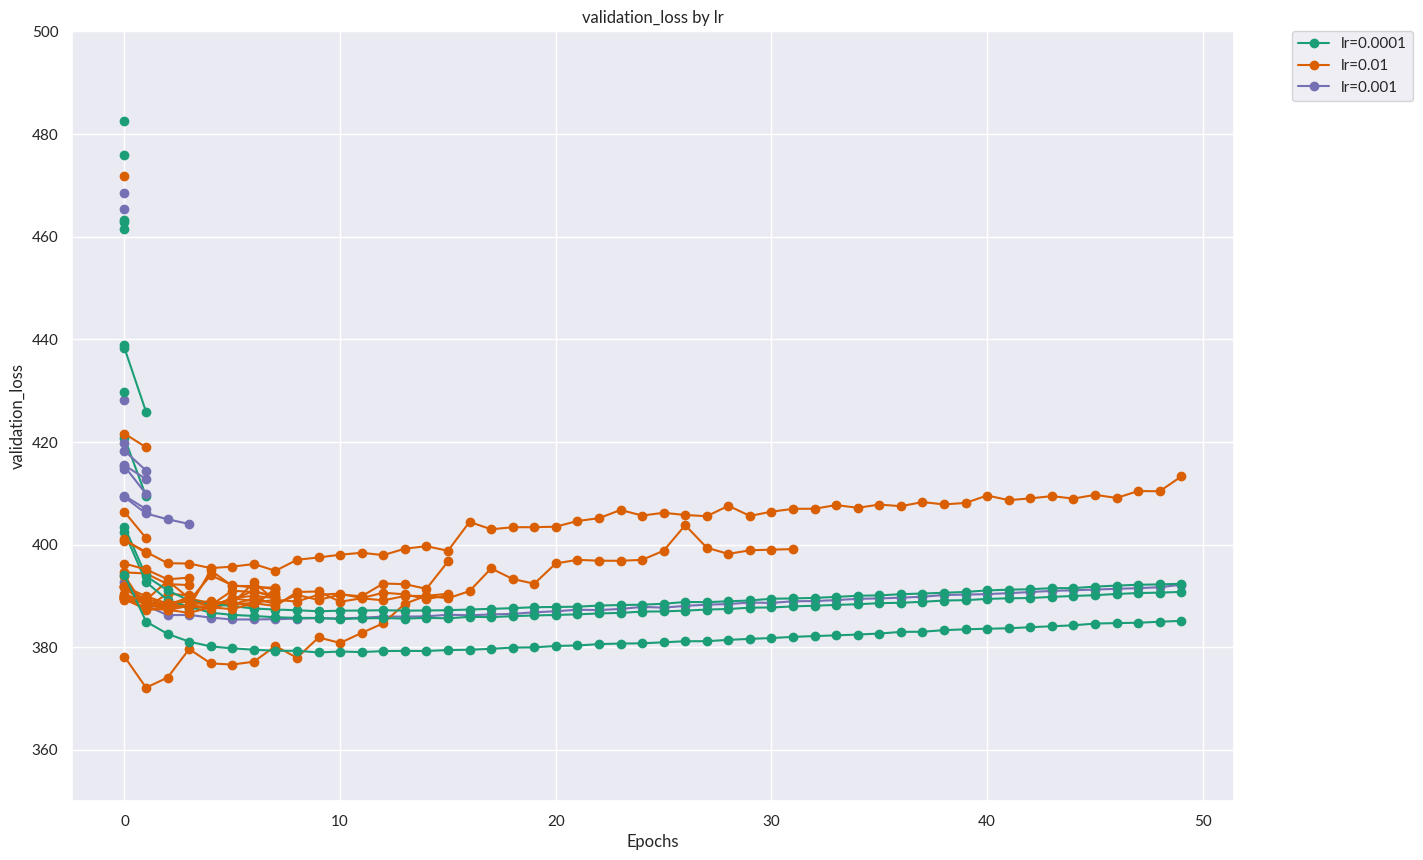

In [16]:
experiment_id = "2023_08_22_human_tenth"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "lr",
    figsize=(15, 10),
    ylim=(350, 500),
)

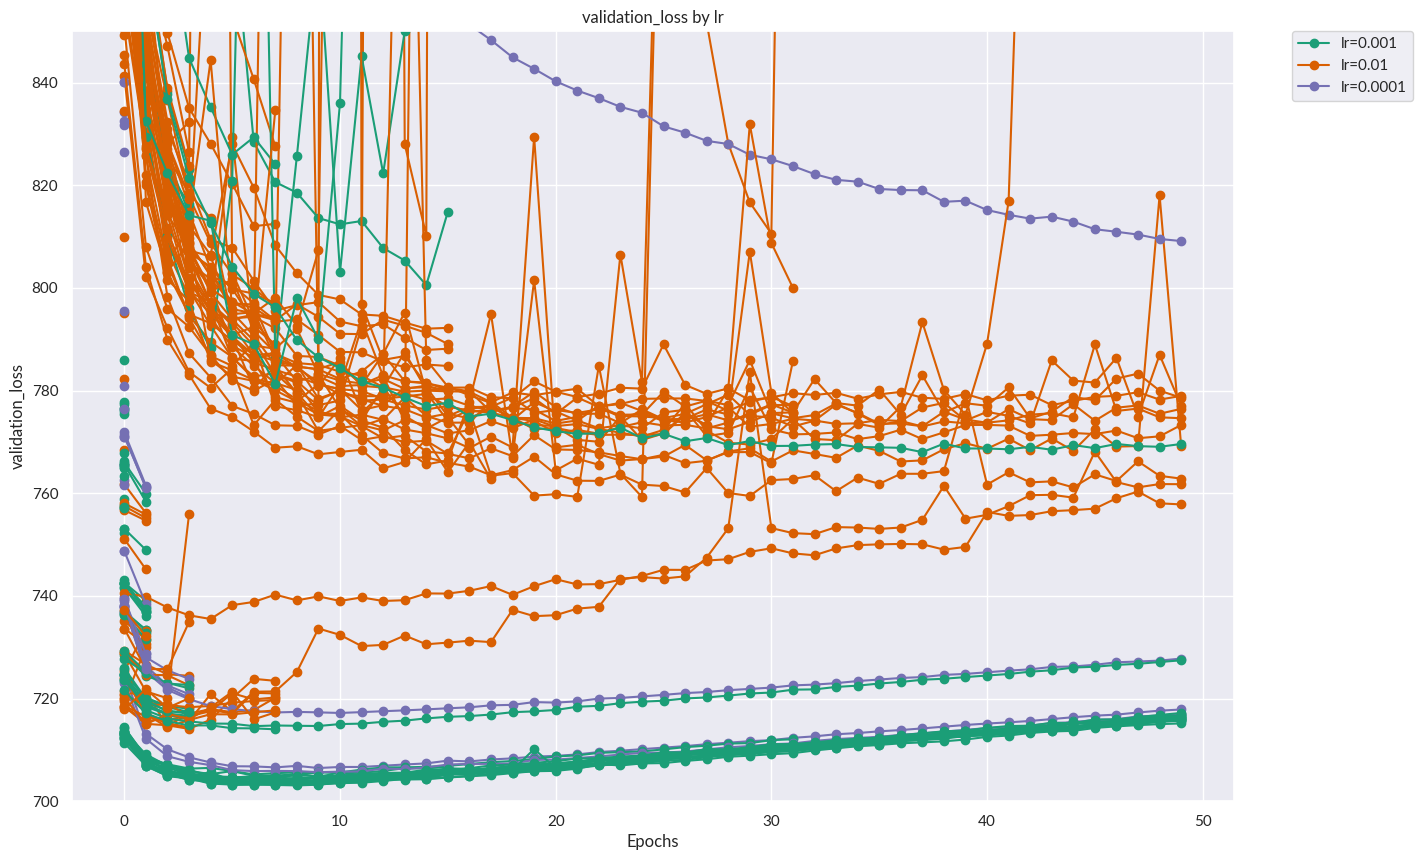

In [39]:
experiment_id = "2023_08_22_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "lr",
    figsize=(15, 10),
    ylim=(700, 850),
)

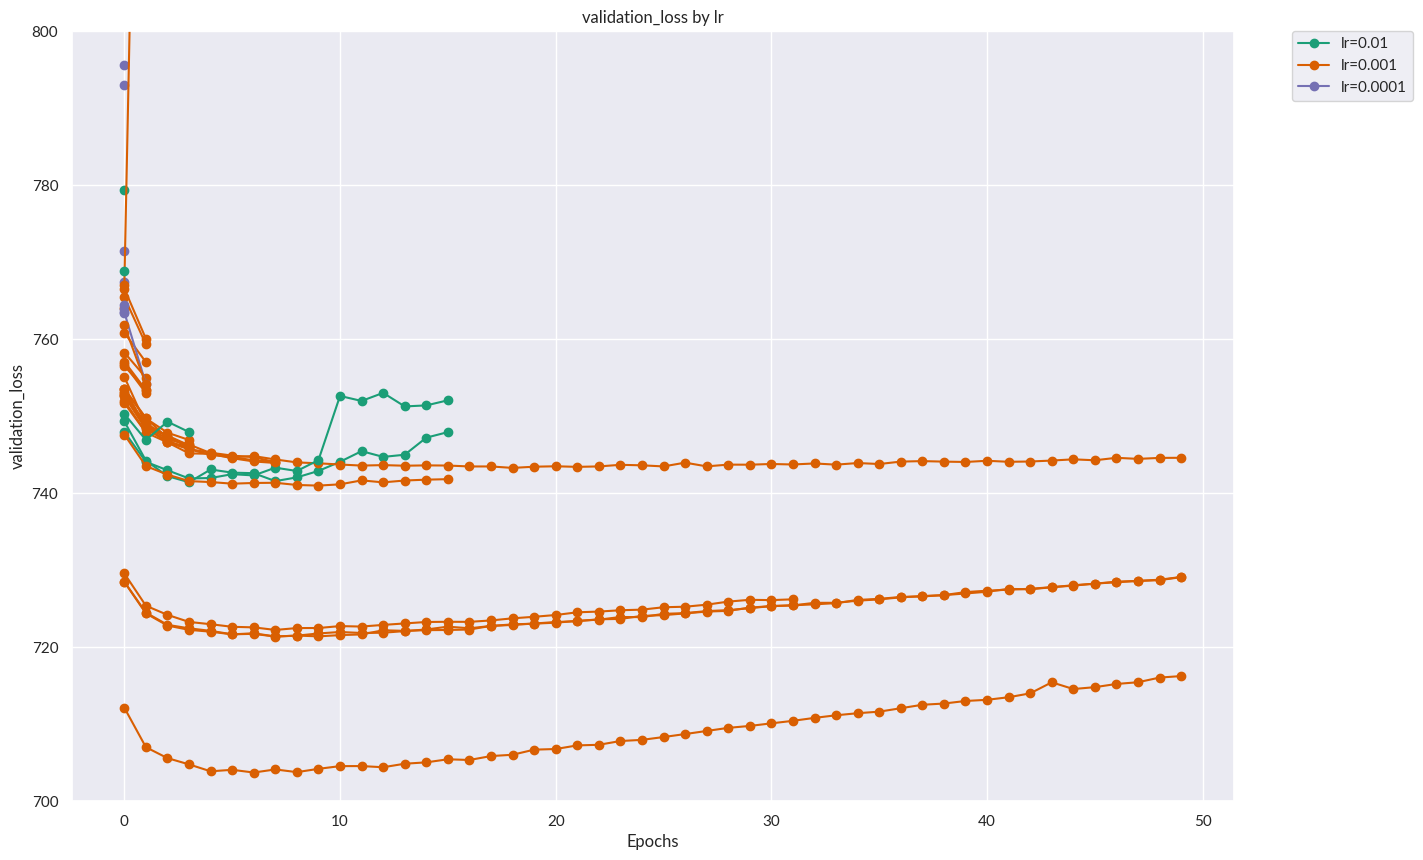

In [18]:
experiment_id = "2023_09_06_mouse_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "lr",
    figsize=(15, 10),
    ylim=(700, 800),
)

### `batch_size`

Finally, we explore the relationship of the minibatch size to model performance. A larger batch size allows for faster training (depending on the hardware) and more accurate estimates of the true gradient, while a smaller batch size can be beneficial by introducing noise into the optimization progress, which can be helpful for exploring model parameters more widely. A rule of thumb in deep learning models is that the learning rate should scale linearly with the batch size.

What we find in our experiments, however, is that the batch size does not seem to affect model performance significantly - we see all three batch sizes in the top-performing models across all experiments, with an intermediate batch size (`1024`) being slightly better on smaller datasets (human tenth and full mouse). Differences in performance are not as dramatic as seen for other parameters, so any of the values in the search space seem like reasonable choices.

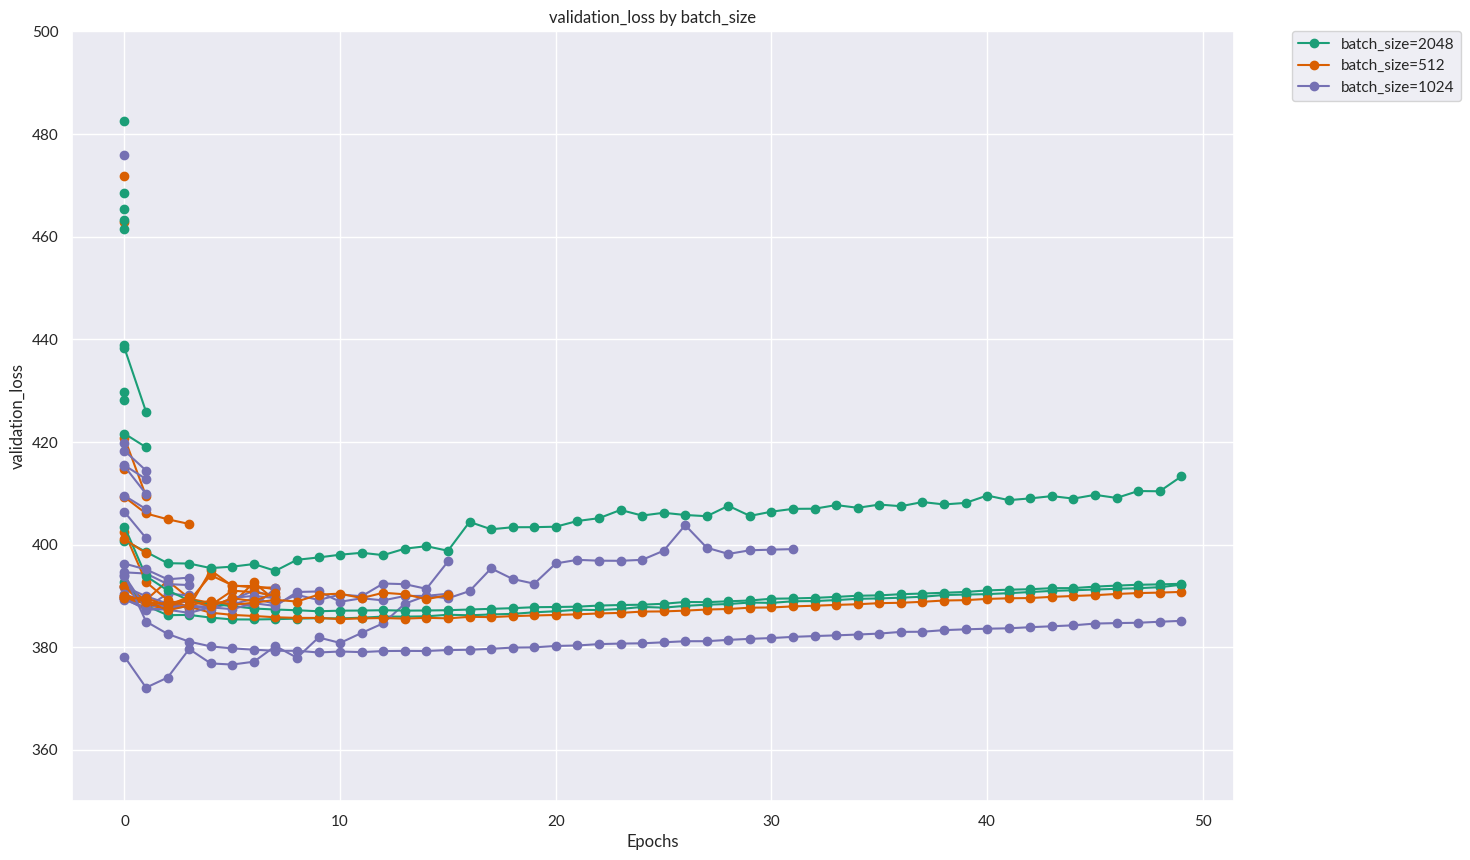

In [19]:
experiment_id = "2023_08_22_human_tenth"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "batch_size",
    figsize=(15, 10),
    ylim=(350, 500),
)

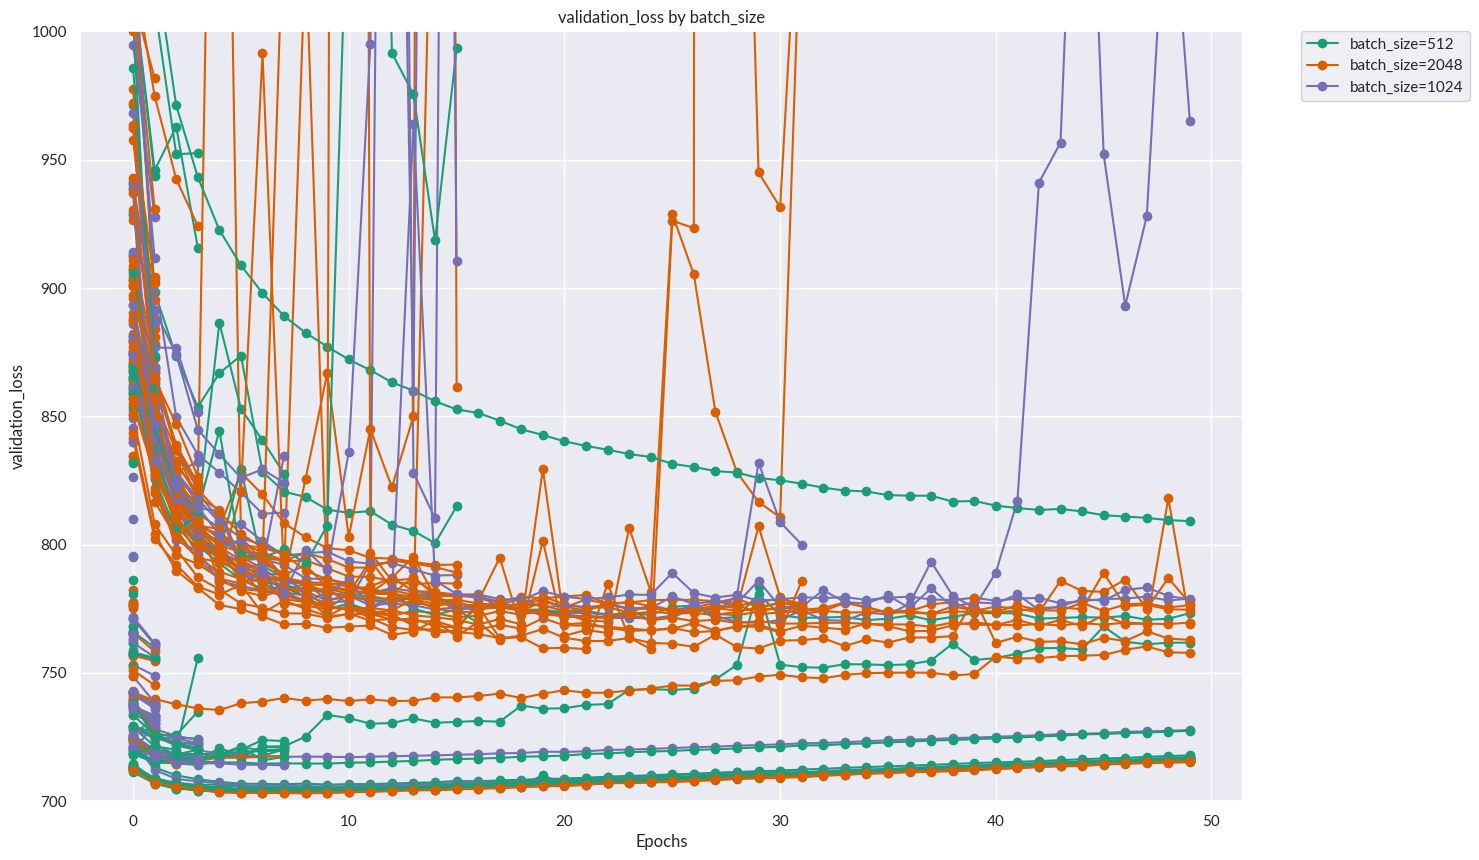

In [20]:
experiment_id = "2023_08_22_human_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "batch_size",
    figsize=(15, 10),
    ylim=(700, 1000),
)

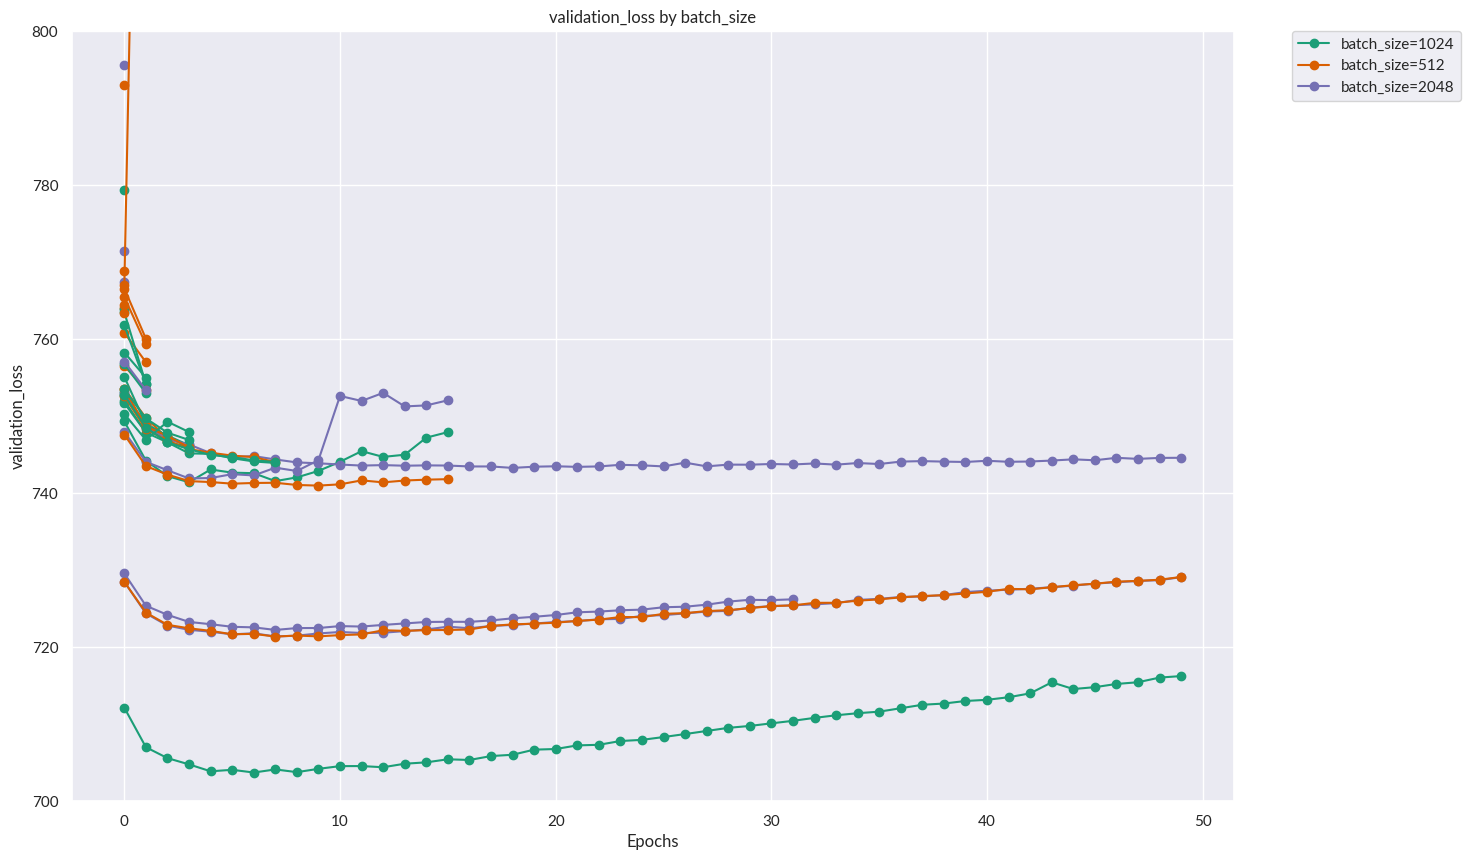

In [21]:
experiment_id = "2023_09_06_mouse_full"
plot_trials(
    experiments[experiment_id][TRIAL_INFO_KEY],
    experiments[experiment_id][TRIAL_PROGRESS_KEY],
    experiments[experiment_id][TRIAL_PARAMS_KEY],
    "batch_size",
    figsize=(15, 10),
    ylim=(700, 800),
)

## 4. Discussion

In conclusion, we observe the following about the model and training parameters explored in these autotune experiments:

- Scaling up the model size (`n_hidden=512`, `n_latent=100,200`) leads to important performance gains across all datasets, with the exception of `n_layers` where the default value of `1` is overwhemingly better
- Models with smaller learning rates (`lr=1e-4,1e-3`) tend to train with more stability and less overfitting.
- `batch_size` does not seem to have a significant effect on model performance, thus it is advisable to choose a larger `batch_size` that maximizes the hardware utilization.
- Models across all datasets tend to converge at around 10 epochs, after which top-performing models overfit slightly.

We would like to explore the following questions based on this:

- Why is the behavior of scaling up `n_layers` much different than `n_latent` or `n_hidden`? Can we introduce any changes to the model that would allow us to increase `n_layers` without a performance dropoff?
- Can we indefinitely increase `batch_size` and expect to see similar model performance?
- Would models benefit from a variable learning rate scheme, such as starting off with a larger learning rate and then gradually decreasing?